In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import hsv_to_rgb
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from matplotlib.patches import Rectangle
from skimage.measure import label, regionprops, regionprops_table
from skimage.io import imread, imshow

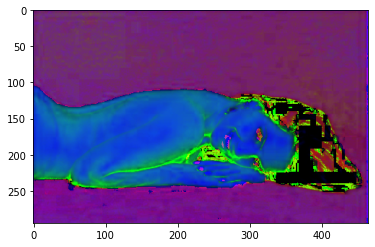

In [2]:
nudez = cv2.imread('./images/nudez.jpg')
nudez = cv2.cvtColor(nudez, cv2.COLOR_BGR2HSV)
plt.imshow(nudez)
plt.show()

### Pega H e S dos recortes de pele

H, hue in OpenCV varies from 0 to 180, but in the outer world it is usually measured in degrees from 0 to 360, so to get the H of your color h = 97.5° / 2 = 48.7

S and V are measured from 0 ( = 0% in outer world) to 255 ( = 100% in outer world), so

s = 255 * 5.1% = 13
v = 255 * 61.57% = 157

https://stackoverflow.com/questions/57469394/opencv-choosing-hsv-thresholds-for-color-filtering

OBS: escala do OPENCV é diferente

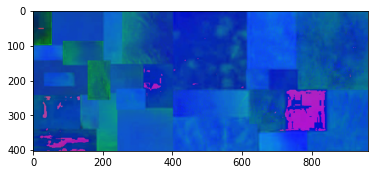

In [3]:
paleta = cv2.imread('./images/recorte_pele.jpg')
paleta = cv2.cvtColor(paleta, cv2.COLOR_BGR2HSV)
plt.imshow(paleta)
plt.show()

In [4]:
all_hsv_codes = paleta.reshape(-1, paleta.shape[-1])
all_hs_codes = [[h,s] for h,s,v in all_hsv_codes]
unique_hs = np.unique(all_hs_codes, axis=0)

In [5]:
unique_hs_x = [h*2 for h,s in unique_hs]
unique_hs_y = [s/255 for h,s in unique_hs]

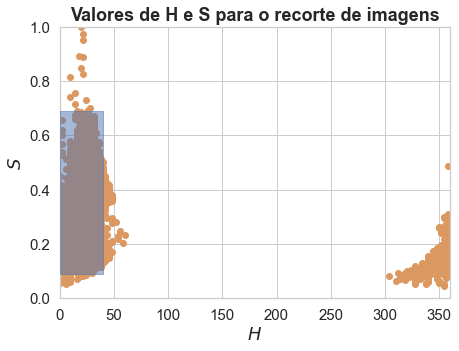

In [6]:
fig = plt.figure(figsize = (7,5))
sns.set_theme(style = 'whitegrid')

plt.xlabel('$H$', fontsize = 18)
plt.ylabel('$S$', fontsize = 18)

plt.xlim(0,360)
plt.ylim(0,1)

plt.scatter(unique_hs_x,unique_hs_y,c = '#DB9961')

plt.title(
    f'Valores de H e S para o recorte de imagens',
    fontsize= 18,
    fontweight = 'bold',
    y = 1
) 

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

# Adicionando faixa de interesse
# Valor real (Open CV): H[0,20] e S[25,180]
plt.gca().add_patch(
   Rectangle(
       (0,0.09),
       40,
       0.6,
       fill=True, 
       color='b', 
       alpha=0.5, 
       zorder=100, 
       figure=fig
       )
   )

plt.savefig(
    f'./graficos/distribuicao_H_S.pdf',
    dpi=1200,
    bbox_inches='tight'
)

### Aplica máscara

In [7]:
x = nudez.shape[0]
y = nudez.shape[1]

mask = np.zeros((x+1,y+1))

for i in range(0,x):
    for j in range(0,y):

        h,s,v = nudez[i,j,:]

        if (0 <= h <= 20) and (25 <= s <= 180):

            mask[i,j] = 1

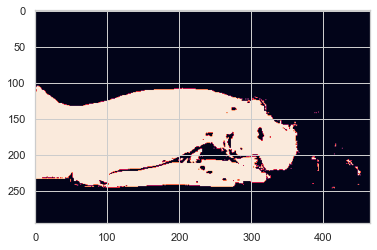

In [8]:
plt.imshow(mask)
plt.show()

### Opening e Closing

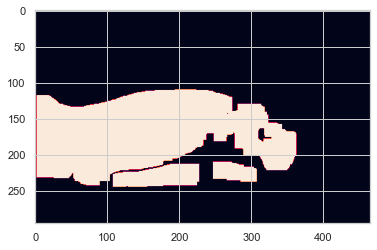

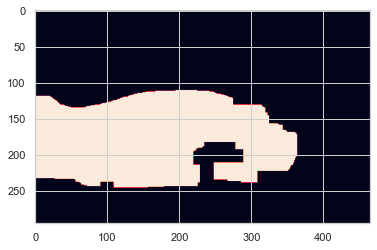

In [89]:
kernel = np.ones((18,18),np.uint8)
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
plt.imshow(opening)
plt.show()

closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing)
plt.show()

### Rotulação e Contagem de Elementos Conectados

c:\Users\erica\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


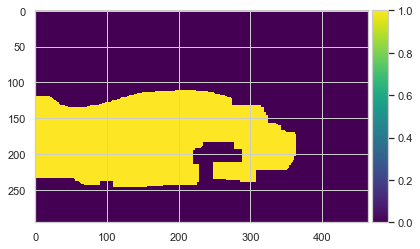

In [121]:
label_image = label(closing)
regions = regionprops(label_image)
imshow(label_image)

### Medição da Área do Maior Elemento Conectado

In [113]:
flat_label_image = label_image.flatten()

# Número de regiões
num_regioes = max(flat_label_image)

In [114]:
regioes_dict = {}

# não leva em conta os que tem indice 0
for i in range(1,int(num_regioes)+1):

    regioes_dict[str(i)] = len(np.where(flat_label_image == i)[0])

lista_chaves = list(regioes_dict.keys())
lista_valores = list(regioes_dict.values())
 
position = lista_valores.index(max(lista_valores))
maior_regiao_indice = lista_chaves[position]

In [115]:
area_imagem = x*y
area_regiao = regioes_dict[maior_regiao_indice]

porcentagem_ocupada = (area_regiao/area_imagem)*100

In [116]:
porcentagem_ocupada

27.82437171244886

### Mostrando imagem com maior regiao

In [122]:
array_regiao = np.copy(label_image)

In [124]:
array_regiao[array_regiao != int(maior_regiao_indice)] = 0
array_regiao[array_regiao == int(maior_regiao_indice)] = 1

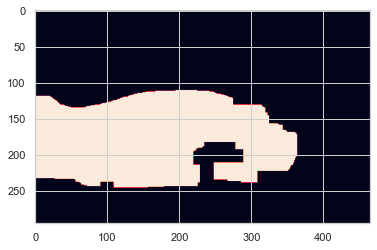

In [125]:
plt.imshow(array_regiao)

### Classificando a partir do treino

In [126]:
if porcentagem_ocupada >= num_regioes:
    print('Nudez detectada')

else:
    print('Imagem segura')

Nudez detectada


### Pega dataset nudez